## Abstract

In this notebook, I tried basic EDA.
In the latter part, I made animated GIF of sampled landmarks.

## Change History

* version1: plot whole body
* version2: plot only upper body (since leg part sometimes contains noise)
* version3: output in mp4 format
* version4: interpolate missing frames

In [1]:
!pip install nb-black

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.4 MB/s eta 0:00:0000:0100:01
  Created wheel for nb-black: filename=nb_black-1.0.7-py3-none-any.whl size=5281 sha256=e8bc4a3cee399cf39ef8b2158a30a372287f22eb0205410bd3a4796dad65ec15
  Stored in directory: /home/gezi/.cache/pip/wheels/3e/50/5e/a46105d019fecb99c1fa1ad6205fa1db47b17fbcee0dbb84a3
Successfully built nb-black


In [18]:
from typing import Dict
from pathlib import Path
from types import SimpleNamespace
from multiprocessing import Pool
from functools import partial

import polars as pl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.core.display import Video
from tqdm import tqdm

plt.style.use("ggplot")

cfg = SimpleNamespace()
cfg.INPUT = Path("/kaggle/input/asl-fingerspelling")
cfg.OUTPUT = Path("/kaggle/input/asl-fingerspelling/animation")
cfg.DEBUG = True

%load_ext lab_black
%load_ext autoreload
%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
train = pl.read_csv(cfg.INPUT / "train.csv")

In [20]:
print(f"#unique participants: {len(train['participant_id'].unique())}")
print(f"#unique sequence: {len(train['sequence_id'].unique()):,}")
print(f"#unique signs: {len(train['sign'].unique()):,}")

#unique participants: 94
#unique sequence: 67,208


ColumnNotFoundError: sign

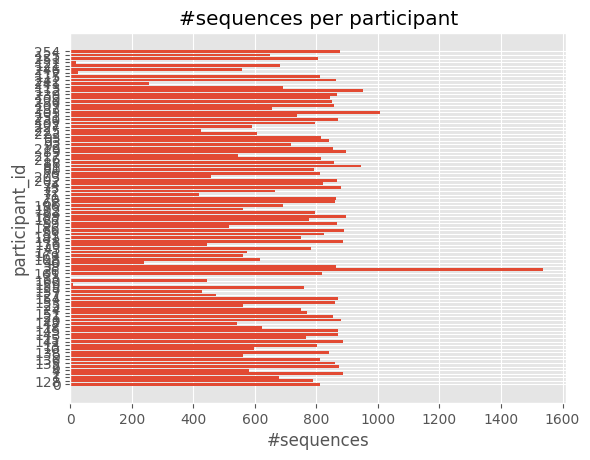

In [21]:
sequence_per_participant = (
    train.groupby("participant_id")
    .agg(pl.col("sequence_id").unique().count())
    .with_columns(pl.col("participant_id").cast(str))
)

_, ax = plt.subplots()
ax.barh(
    y=sequence_per_participant["participant_id"],
    width=sequence_per_participant["sequence_id"],
)
ax.set(xlabel="#sequences", ylabel="participant_id", title="#sequences per participant")
plt.show()

In [23]:
# sequence_per_sign = (
#     train.groupby("sign").agg(pl.col("sequence_id").count()).sort("sequence_id")
# )
# _, ax = plt.subplots()
# ax.hist(sequence_per_sign["sequence_id"], bins=20)
# ax.set(xlabel="#sequences/sign", ylabel="count", title="#sequences per sign")
# plt.show()

## Skeletical data

In [24]:
edges = {
    "left_hand": [
        (0, 1),
        (1, 2),
        (2, 3),
        (3, 4),
        (0, 5),
        (0, 17),
        (5, 6),
        (6, 7),
        (7, 8),
        (5, 9),
        (9, 10),
        (10, 11),
        (11, 12),
        (9, 13),
        (13, 14),
        (14, 15),
        (15, 16),
        (13, 17),
        (17, 18),
        (18, 19),
        (19, 20),
    ],
    "right_hand": [
        (0, 1),
        (1, 2),
        (2, 3),
        (3, 4),
        (0, 5),
        (0, 17),
        (5, 6),
        (6, 7),
        (7, 8),
        (5, 9),
        (9, 10),
        (10, 11),
        (11, 12),
        (9, 13),
        (13, 14),
        (14, 15),
        (15, 16),
        (13, 17),
        (17, 18),
        (18, 19),
        (19, 20),
    ],
    "pose": [
        (8, 6),
        (6, 5),
        (6, 4),
        (4, 0),
        (0, 1),
        (1, 2),
        (2, 3),
        (3, 7),
        (10, 9),
        (11, 12),
        (11, 13),
        (11, 23),
        (13, 15),
        (15, 21),
        (15, 17),
        (15, 19),
        (17, 19),
        (12, 14),
        (12, 24),
        (14, 16),
        (16, 22),
        (16, 20),
        (16, 18),
        (18, 20),
        (23, 24),
        # discard landmarks of lower body
        # (24, 26),
        # (26, 28),
        # (28, 30),
        # (28, 32),
        # (30, 32),
        # (23, 25),
        # (25, 27),
        # (27, 29),
        # (27, 31),
        # (29, 31),
    ],
}

In [25]:
lm_data = {k: v for k, v in zip(train.columns, train.row(0))}

df_landmark = pl.read_parquet(cfg.INPUT / lm_data["path"])
lm_first_frame = df_landmark.partition_by("frame")[0]
lms = lm_first_frame.partition_by("type")

_, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()

for lm, ax in zip(lms, axes):
    lm = lm.filter((pl.col("type") != "pose") | (pl.col("landmark_index") < 25))
    lm_type = lm.row(0)[2]
    ax.scatter(lm["x"], lm["y"])
    if lm_type != "face":
        for row in lm.iter_rows():
            dt = {k: v for k, v in zip(lm.columns, row)}
            x, y, idx = dt["x"], dt["y"], dt["landmark_index"]

            if (x is not None) & (y is not None):
                ax.text(x, y, idx)
    if lm_type in ["left_hand", "right_hand", "pose"]:
        for edge in edges[lm_type]:
            i, j = edge
            x1, x2, y1, y2 = lm["x"][i], lm["x"][j], lm["y"][i], lm["y"][j]
            if not ((x1 is None) | (x2 is None) | (y1 is None) | (y2 is None)):
                ax.plot((x1, x2), (y1, y2), color="gray")
    ax.set(title=f"{lm_type}")
    ax.invert_yaxis()

ColumnNotFoundError: type

NameError: name 'df_landmark' is not defined

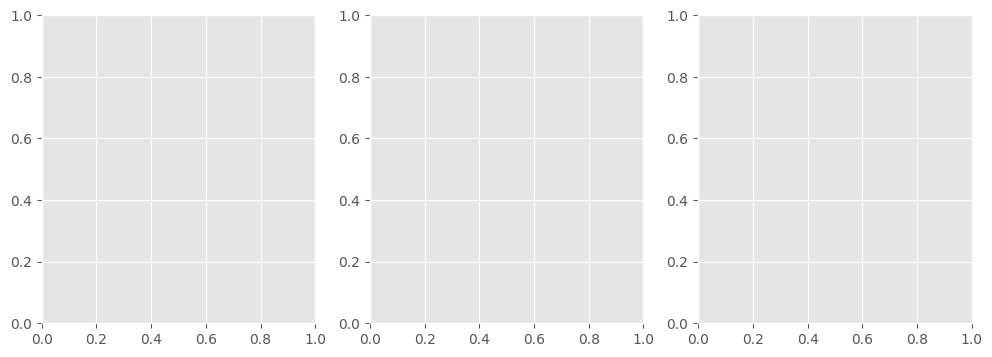

In [9]:
_, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, col in zip(axes, ["x", "y", "z"]):
    ax.hist(df_landmark[col], bins=20, alpha=0.5, label=col)
    ax.set(xlabel=col)
plt.suptitle("Distribution of axes of normalized coordinate")
plt.show()

## Making Amination

In [10]:
def make_animation(row, columns, fps: int = 10):
    data = {k: v for k, v in zip(columns, row)}
    sign, participant_id, sequence_id = (
        data["sign"],
        data["participant_id"],
        data["sequence_id"],
    )

    df_landmark = pl.read_parquet(cfg.INPUT / data["path"])
    use_cols = ["x", "y", "z"]
    df_landmark = df_landmark.sort(["frame", "type", "landmark_index"]).with_columns(
        [pl.col(col).interpolate().over(["type", "landmark_index"]) for col in use_cols]
    )

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes = axes.ravel()

    lms_all = df_landmark.partition_by("frame")

    def draw_frame(frame):
        lms = lms_all[frame].partition_by("type")

        for lm, ax in zip(lms, axes):
            lm = lm.filter((pl.col("type") != "pose") | (pl.col("landmark_index") < 25))
            ax.cla()
            lm_type = lm.row(0)[2]
            frame = lm.row(0)[0]

            ax.scatter(lm["x"], lm["y"])
            if lm_type != "face":
                for row in lm.iter_rows():
                    dt = {k: v for k, v in zip(lm.columns, row)}
                    if (dt["x"] is not None) & (dt["y"] is not None):
                        ax.text(dt["x"], dt["y"], dt["landmark_index"])
            if lm_type in ["left_hand", "right_hand", "pose"]:
                for edge in edges[lm_type]:
                    i, j = edge
                    x1, x2, y1, y2 = lm["x"][i], lm["x"][j], lm["y"][i], lm["y"][j]
                    if not ((x1 is None) | (x2 is None) | (y1 is None) | (y2 is None)):
                        ax.plot((x1, x2), (y1, y2), color="gray")
            ax.set(title=f"{lm_type}")
            ax.invert_yaxis()
        plt.suptitle(f'sign: "{sign}" [frame={frame}]')

    ani = animation.FuncAnimation(
        fig, draw_frame, frames=range(len(lms_all)), interval=1000 / fps
    )

    if not (cfg.OUTPUT / sign).exists():
        (cfg.OUTPUT / sign).mkdir()
    ani.save(
        cfg.OUTPUT / sign / f"{participant_id}_{sequence_id}.mp4",
        writer="ffmpeg",
        fps=fps,
        codec="h264",
    )
    plt.close(fig)

Choose 5 samples per each group

In [11]:
train_unique_signs = train.filter(
    (pl.arange(0, pl.count())).shuffle(seed=42).over("sign") < 5
)

NameError: name 'train' is not defined

In [12]:
train_unique_signs.groupby("sign").agg(pl.count()).head()

NameError: name 'train_unique_signs' is not defined

In [13]:
if not cfg.OUTPUT.exists():
    cfg.OUTPUT.mkdir()

if cfg.DEBUG:
    df = train_unique_signs.head(4)
else:
    df = train_unique_signs

for row in tqdm(df.iter_rows(), total=len(df)):
    make_animation(row, df.columns)

NameError: name 'train_unique_signs' is not defined

In [14]:
!du -sh animation

du: cannot access 'animation': No such file or directory


In [15]:
!tree animation | head

/bin/bash: line 1: tree: command not found


## Generated Animations

You can access to the full 250 class of signs in [ISLR: Animated 250 Sampled Signs](https://www.kaggle.com/datasets/tatamikenn/islr-animation-250-signs).


In [16]:
!cp animation/all/26734_1247514751.mp4 sample001.mp4
!cp animation/bug/61333_1268993802.mp4 sample002.mp4
!cp animation/lion/29302_1271911796.mp4 sample003.mp4
!cp animation/TV/28656_125816896.mp4 sample004.mp4

cp: cannot stat 'animation/all/26734_1247514751.mp4': No such file or directory
cp: cannot stat 'animation/bug/61333_1268993802.mp4': No such file or directory
cp: cannot stat 'animation/lion/29302_1271911796.mp4': No such file or directory
cp: cannot stat 'animation/TV/28656_125816896.mp4': No such file or directory


In [17]:
Video("sample001.mp4")

ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')

In [ ]:
Video("sample002.mp4")

In [ ]:
Video("sample003.mp4")

In [ ]:
Video("sample004.mp4")

In [ ]:
!zip -r animation.zip {cfg.OUTPUT.relative_to("/kaggle/working")} && rm -rf {cfg.OUTPUT}